In [2]:
import numpy as np
import pandas as pd
import ot
import os.path
import os
from IPython.display import Image, display
import matplotlib
import matplotlib.pyplot as plt
import math
from functools import reduce, partial
import operator
from collections import Counter, defaultdict
from scipy.sparse import coo_matrix, diags
from scipy.sparse.linalg import norm
from scipy.spatial.distance import pdist, squareform
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import networkx as nx

%matplotlib inline

POSTERS_DIRECTORY = os.path.join(os.getcwd(), 'posters')
EMBEDDINGS_DIRECTORY = os.path.join(os.getcwd(), 'data')
RATING_VALUES = {'favorite': 1, 'like': 1, 'dislike': 0, 'neutral': 0, 'willsee': 1, 'wontsee': 0}

In [3]:
class Embedding:
    def __init__(self, npy_filename, posters_paths=None):
        self.npy_filename = npy_filename
        self.posters_paths = posters_paths or []
        
        self.npy = None
        self.work_ids = []
        self.read_work_ids_from_posters_paths()
        
    def open_npy(self):
        self.npy = np.load(self.npy_filename)
    
    def read_posters_paths_from_filename(self, posters_filename):
        self.posters_paths = []
        with open(posters_filename, 'r') as f:
            for line in f:
                filename = os.path.basename(line.strip())
                self.posters_paths.append(os.path.join(POSTERS_DIRECTORY, filename))
        
        self.read_work_ids_from_posters_paths()
    
    def read_work_ids_from_posters_paths(self):
        for p in self.posters_paths:
            work_id = os.path.basename(p)[:-len('.jpg')]
            try:
                self.work_ids.append(int(work_id))
            except ValueError:
                print('[!] Invalid poster data!')
    
    @property
    def identifier(self):
        return os.path.basename(self.npy_filename)[len('embeddings-'):-len('.npy')]
    
    def generate_collage(self, work_directory=None):
        PER_ROW = 4
        if work_directory is None:
            work_directory = POSTERS_DIRECTORY
        target_path = os.path.join(work_directory, 'montage-{}.png'.format(self.identifier))
        if os.path.exists(target_path):
            print('[!] Overwriting a montage')
            os.remove(target_path)
        os.system('montage -density 300 -tile {}x0 -geometry +5+50 -border 10 {} {}'
                 .format(PER_ROW, ' '.join(self.posters_paths), target_path))
    
    def show_collage(self, work_directory=None):
        if work_directory is None:
            work_directory = POSTERS_DIRECTORY
        
        return Image(os.path.join(work_directory, 'montage-{}.png'.format(self.identifier)))
    
    def show_image(self, work_id, work_directory=None):
        if work_directory is None:
            work_directory = POSTERS_DIRECTORY
        
        return Image(os.path.join(work_directory, '{}.jpg'.format(work_id)))
    
    def show_images_grid(self):
        """
            Relatively slow.
        """
        files = []
        try:
            files = []
            for poster_path in self.posters_paths:
                files.append(open(poster_path, 'rb'))
            
            PER_ROW = 3
            # FIXME: can we go smaller than 100 × 500 while preserving a decent visual overview?
            _, axarr = plt.subplots(math.ceil(len(files)/PER_ROW), PER_ROW, figsize=(100, 500))
            for index, file in enumerate(files):
                a = plt.imread(file)
                col = index % PER_ROW
                row = index // PER_ROW
                # FIXME: can we improve the speed?
                axarr[row, col].imshow(a, aspect='equal', interpolation='none')
        finally:
            for file in files:
                file.close()
        
        
    
    def __repr__(self):
        if self.npy is not None:
            return '<Embedding (opened): {} × {}>'.format(*self.npy.shape)
        else:
            return '<Embedding (closed)>'
    
    @classmethod
    def from_filename(cls, embedding_filename, ignore_posters=False):
        emb_basename = os.path.basename(embedding_filename)
        poster_basename = 'paths-' + emb_basename[len('embeddings-'):-len('.npy')] + '.txt'
        posters_filenames = os.path.join(os.path.dirname(embedding_filename), poster_basename)
        
        if not os.access(posters_filenames, os.R_OK) and not ignore_posters:
            raise ValueError('Posters paths are not available!')
        
        embedding = Embedding(embedding_filename)
        if not ignore_posters:
            embedding.read_posters_paths_from_filename(posters_filenames)
        
        return embedding

work_ids_images = {}
        
def generate_mapping(work_directory=None):
    if work_directory is None:
        work_directory = EMBEDDINGS_DIRECTORY
    
    mapping = []
    files_list = os.listdir(work_directory)
    
    for filename in files_list:
        if filename.startswith('embeddings-'):
            try:
                embedding = Embedding.from_filename(os.path.join(work_directory, filename))
                for work_id in embedding.work_ids:
                    work_ids_images[work_id] = partial(embedding.show_image, work_id)
                mapping.append(embedding)
                print('[+] {} has been loaded in the database'.format(filename))
            except Exception as e:
                print('[-] {} is a lonely embedding ({})'.format(filename, e))
    
    return mapping

In [4]:
embeddings = generate_mapping()

[+] embeddings-2019-02-18T15-06-33.206256.npy has been loaded in the database
[+] embeddings-2019-02-18T15-32-40.869138.npy has been loaded in the database
[+] embeddings-2019-02-18T15-00-26.042690.npy has been loaded in the database
[+] embeddings-2019-02-18T16-40-31.289213.npy has been loaded in the database
[+] embeddings-2019-02-18T15-21-12.271421.npy has been loaded in the database
[+] embeddings-2019-02-18T15-18-11.900064.npy has been loaded in the database
[+] embeddings-2019-02-18T15-02-46.318452.npy has been loaded in the database
[+] embeddings-2019-02-18T16-42-45.508436.npy has been loaded in the database
[+] embeddings-2019-02-18T15-18-40.921292.npy has been loaded in the database
[+] embeddings-2019-02-18T15-17-40.644516.npy has been loaded in the database
[+] embeddings-2019-02-18T15-24-43.402070.npy has been loaded in the database
[+] embeddings-2019-02-18T16-41-16.244661.npy has been loaded in the database
[+] embeddings-2019-02-18T15-25-14.291466.npy has been loaded in

In [5]:
for embedding in embeddings:
    embedding.open_npy()

In [6]:
# Check for potential mismatches
from itertools import chain
A = set(sorted(list(chain(*[embedding.work_ids for embedding in embeddings]))))
B = set(range(1, max(A) + 1))
len(A ^ B)

5927

In [9]:
def load_ratings(path):
    df = pd.read_csv(path)
    triplets = np.array(df[['user', 'item', 'rating']], dtype=np.object)
    vectorized_convert = np.vectorize(RATING_VALUES.get, otypes=[np.float64])
    X = triplets[:,0:2].astype(np.int32)
    y = vectorized_convert(triplets[:,2])
    nb_users = int(max(triplets[:,0]) + 1)
    nb_works = int(max(triplets[:,1]) + 1)
    
    return df, X, y, nb_users, nb_works


_, X, y, nb_users, nb_works = load_ratings(os.path.join(EMBEDDINGS_DIRECTORY, 'ratings.csv'))

In [10]:
def merge_and_order_embeddings(embeddings):
    flattened = []
    
    for embedding in embeddings:
        for index, work_id in enumerate(embedding.work_ids):
            flattened.append((embedding.npy[index].reshape((1, 512)), work_id))
    
    ordered_embeddings = sorted(flattened,
                               key=lambda item: item[1])
    
    C = np.concatenate([x for x, _ in ordered_embeddings], axis=0)
    work_ids = [y for _, y in ordered_embeddings]
    
    return C, work_ids

C, work_ids = merge_and_order_embeddings(embeddings)

In [11]:
left_slider = widgets.IntSlider(min=1, max=nb_works)
right_slider = widgets.IntSlider(min=1, max=nb_works)
distance = widgets.Label(value='Distance: {}')

def show_static_img(left):
    if left in work_ids_images:
        display(work_ids_images[left]())
    else:
        display('[!] Work ID not in DB')


def distance_(left, right):
    try:
        X = C[left] - C[right]
        return X @ X.T
    except:
        return 'N/A'
        
def handle_slider_change(_):
    distance.value = 'Distance: {}'.format(distance_(left_slider.value, right_slider.value))
    
w1 = interactive(show_static_img, left=left_slider)
w2 = interactive(show_static_img, left=right_slider)

handle_slider_change(None)
left_slider.observe(handle_slider_change, names='value')
right_slider.observe(handle_slider_change, names='value')

display(widgets.HBox([w1, w2, distance]))

In [41]:
# Adapted from mangaki.zero.knn module

def normalize(X):
    norms = norm(X, axis=1)
    norms[norms == 0] = 1.
    return diags(1 / norms) @ X


# Linear kernel
def cosine_similarity(X, Y=None):
    X = normalize(X)
    if Y is None:
        Y = X
    else:
        Y = normalize(Y)
    return (X @ Y.T).toarray()


def mean_of_nonzero(X, cols):
    X_csc = X.tocsc()
    sums = X_csc[:, cols].sum(axis=0).A1
    counts = np.diff(X_csc.indptr)[cols]
    counts[counts == 0] = 1.
    return sums / counts

class KNN:
    def __init__(self, nb_users, nb_works, nb_neighbors=20, rated_by_neighbors_at_least=3,
                 missing_is_mean=True, weighted_neighbors=False):
        self.nb_users = nb_users
        self.nb_works = nb_works
        self.M = None
        self.nb_neighbors = nb_neighbors
        self.rated_by_neighbors_at_least = rated_by_neighbors_at_least
        self.missing_is_mean = missing_is_mean
        self.weighted_neighbors = weighted_neighbors
        self.closest = {}
        self.rated_works = {}
        self.mean_score = {}
        self.ratings = {}
        self.sum_ratings = {}
        self.nb_ratings = {}
    
    def get_user_probability_distribution(self, user_id):
        """
        returns r_u as a vector of nb_works such that sum equals to 1.
        """
        return self.M[user_id]

    def compute_optimal_transport(self, cost_matrix, a_user, b_user, **extra_params):
        r_a = get_user_probability_distribution(a_user)
        r_b = get_user_probability_distribution(b_user)
        
        return ot.bregman.greenkhorn(r_a, r_b, cost_matrix, **extra_params)
        
    def get_neighbors(self, user_ids=None):
        neighbors = []
        if user_ids is None:
            score = cosine_similarity(self.M)  # All pairwise similarities
            user_ids = range(self.nb_users)
        else:
            score = cosine_similarity(self.M[user_ids], self.M)
        for i, user_id in enumerate(user_ids):
            if self.nb_neighbors < self.nb_users - 1:
                # Do not select the user itself while looking at neighbors
                score[i][user_id] = float('-inf')
                # Put top NB_NEIGHBORS user indices at the end of array,
                # no matter their order; then, slice them!
                neighbor_ids = (
                    score[i]
                    .argpartition(-self.nb_neighbors - 1)
                    [-self.nb_neighbors - 1:-1]
                )
            else:
                neighbor_ids = list(range(self.nb_users))
                neighbor_ids.remove(user_id)
            neighbors.append(neighbor_ids)
            self.closest[user_id] = {}
            for neighbor_id in neighbor_ids:
                self.closest[user_id][neighbor_id] = score[i, neighbor_id]
        return neighbors
    
    def nx_graph_neighbors(self, user_ids=None):
        neighbors = self.get_neighbors(user_ids)
        G = nx.Graph()
        
        for node, neigh in enumerate(neighbors):
            target = user_ids[node] if user_ids else node
            G.add_node(target)
            for sibling in neigh:
                G.add_edge(target, sibling)
        
        return G

    def fit(self, X, y, whole_dataset=False):
        self.ratings = defaultdict(dict)
        self.sum_ratings = Counter()
        self.nb_ratings = Counter()
        users, works = zip(*list(X))
        # Might take some time, but coo is efficient for creating matrices
        self.M = coo_matrix((y, (users, works)),
                            shape=(self.nb_users, self.nb_works)).astype(
                                np.float64)
        # knn.M should be CSR for faster arithmetic operations
        self.M = self.M.tocsr()
        for (user_id, work_id), rating in zip(X, y):
            self.ratings[user_id][work_id] = rating
            self.nb_ratings[work_id] += 1
            self.sum_ratings[work_id] += rating
        for work_id in self.nb_ratings:
            self.mean_score[work_id] = (self.sum_ratings[work_id] /
                                        self.nb_ratings[work_id])

    def fit_single_user(self, rated_works, ratings):
        nb_rated = len(rated_works)
        nb_neighbors = min(self.nb_neighbors, self.nb_users)
        user_ratings = coo_matrix((ratings, ([0.] * nb_rated, rated_works)),
                                  shape=(1, self.nb_works)).tocsr()
        score = cosine_similarity(user_ratings, self.M).reshape(-1)
        return np.argpartition(score, -nb_neighbors)[-nb_neighbors:]

    def predict(self, X):
        # Compute only relevant neighbors
        self.get_neighbors(list(set(X[:, 0])))
        y = []
        for my_user_id, work_id in X:
            weight = 0
            predicted_rating = 0
            nb_neighbors_that_rated_it = 0
            for user_id in self.closest[my_user_id]:
                their_sim_score = self.closest[my_user_id][user_id]
                if self.missing_is_mean:
                    if work_id in self.ratings[user_id]:
                        their_rating = self.ratings[user_id][work_id]
                        nb_neighbors_that_rated_it += 1
                    else:
                        # In case KNN was not trained on this work
                        their_rating = self.mean_score.get(work_id, 0)
                else:
                    their_rating = self.ratings[user_id].get(work_id)
                    if their_rating is None:
                        continue  # Skip
                if self.weighted_neighbors:
                    predicted_rating += their_sim_score * their_rating
                    weight += their_sim_score
                else:
                    predicted_rating += their_rating
                    weight += 1
            if nb_neighbors_that_rated_it < self.rated_by_neighbors_at_least:
                predicted_rating = 0
            if weight > 0:
                predicted_rating /= weight
            y.append(predicted_rating)
        return np.array(y)

    def predict_single_user(self, work_ids, neighbor_ids):
        return mean_of_nonzero(self.M[neighbor_ids], work_ids)

    def __str__(self):
        return '[KNN] NB_NEIGHBORS = %d' % self.nb_neighbors

In [42]:
knn = KNN(nb_users, nb_works)
knn.fit(X, y)

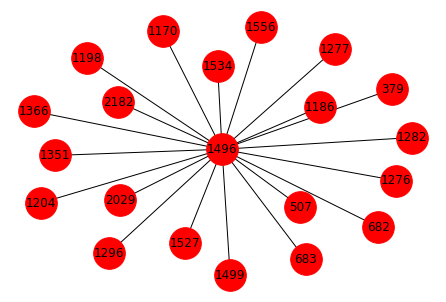

In [200]:
MINIMAL_ITEM_RATED = 200
interesting_user = np.random.choice(np.where(np.count_nonzero(knn.M.toarray(), axis=1) >= MINIMAL_ITEM_RATED)[0])
# me = np.random.randint(1, nb_users)
me = interesting_user
G = knn.nx_graph_neighbors([me])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='red')

In [201]:
def sim(u, u_):
    return ((normalize(knn.M[u]) @ normalize(knn.M[u_]).T)).toarray()[0][0]

print('[+] Looking at {} with {} works'.format(me, np.count_nonzero(knn.M[me].toarray())))
similarities = np.array([sim(me, k) for k in range(nb_users)])

[+] Looking at 1496 with 231 works


In [202]:
disjoint_support_ids, = np.where(similarities == 0)
relevant_targets = sorted([(k, knn.M[k], np.count_nonzero(knn.M[k].toarray())) for k in disjoint_support_ids if np.count_nonzero(knn.M[k].toarray()) > 0],
                          key=lambda t: t[2], reverse=True)

print('[+] Relevant users for Wasserstein metric: {} with the best at: {} disjoint works'.format(len(relevant_targets), relevant_targets[0][2]))

[+] Relevant users for Wasserstein metric: 100 with the best at: 115 disjoint works


In [203]:
target_id, target_works, _ = relevant_targets[0]

def extract_relevant_works(user_vector, remove_inexistant_poster=True):
    _, work_ids = user_vector.nonzero()
    if remove_inexistant_poster:
        work_ids = work_ids[np.array([item in work_ids_images for item in work_ids])]
    return work_ids

me_works = extract_relevant_works(knn.M[me])
target_works = extract_relevant_works(target_works)

print('[+] Comparing {} vs {} works with disjoint support'.format(me_works.shape, target_works.shape))

[+] Comparing (231,) vs (47,) works with disjoint support


In [204]:
def show_img(works, index):
    if works[index] in work_ids_images:
        display(work_ids_images[works[index]]())
    else:
        print('[!] Database mismatch!')

def slideshow_target(target_works):
    return interactive(show_img, works=fixed(target_works), index=widgets.IntSlider(min=0, max=len(target_works) - 1))


w1 = slideshow_target(me_works)
w2 = slideshow_target(target_works)

display(widgets.HBox([w1, w2]));

In [205]:
filtered_r_works = me_works[me_works < C.shape[0]]
filtered_t_works = target_works[target_works < C.shape[0]]

print(filtered_r_works.shape, filtered_t_works.shape)

(231,) (46,)


In [212]:
N_WORKS = 3_000
sampled_works = np.union1d(np.random.choice(filtered_r_works, N_WORKS), np.random.choice(filtered_t_works, N_WORKS))

def user_distribution(user_id, work_support):
    return knn.M[user_id][0,work_support].toarray().reshape(-1)

user_distribution(me, sampled_works), user_distribution(target_id, sampled_works)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

In [213]:
def compute_pairwise_distances(embedding_matrix):
    return pdist(embedding_matrix, 'sqeuclidean')

M = squareform(compute_pairwise_distances(C[sampled_works]))

In [214]:
def normalize_column_vector(x):
    x = np.clip(x, 0, 1) + 1e-6
    return np.abs(x / x.sum())

def compute_user_distribution(user_id):
    return np.asarray(normalize_column_vector(knn.M[user_id, sampled_works].todense())).reshape(-1)

Raito = compute_user_distribution(me)
JJ = compute_user_distribution(1)

def compute_emd(user1, user2, M):
    u = compute_user_distribution(user1)
    u_ = compute_user_distribution(user2)
    
    return ot.emd(u, u_, M)

def compute_wasserstein(user1, user2, M, method='emd'):
    if method == 'emd':
        u = compute_user_distribution(user1)
        u_ = compute_user_distribution(user2)
        
        return ot.emd2(u, u_, M)
    else:
        u = compute_user_distribution(user1)
        u_ = compute_user_distribution(user2)
        
        return ot.sinkhorn_epsilon_scaling2(u, u_, M, 1)
    
    

def compute_sinkhorn(user1, user2, reg=1):
    u = compute_user_distribution(user1)
    u_ = compute_user_distribution(user2)
    
    return ot.bregman.sinkhorn_epsilon_scaling(u, u_, M, reg)


In [215]:
M_normalized = ot.utils.cost_normalization(M, 'max')
M_normalized

array([[0.        , 0.56169846, 0.46394671, ..., 0.57129952, 0.70535643,
        0.61015141],
       [0.56169846, 0.        , 0.46023206, ..., 0.57237867, 0.74201791,
        0.53389901],
       [0.46394671, 0.46023206, 0.        , ..., 0.49178344, 0.66196756,
        0.43767607],
       ...,
       [0.57129952, 0.57237867, 0.49178344, ..., 0.        , 0.58054325,
        0.41314604],
       [0.70535643, 0.74201791, 0.66196756, ..., 0.58054325, 0.        ,
        0.66908985],
       [0.61015141, 0.53389901, 0.43767607, ..., 0.41314604, 0.66908985,
        0.        ]])

[[2.17389995e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.17389995e-08 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.17389995e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.32899914e-09
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  4.32899914e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.32899914e-09]] [[4.32900347e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.38888355e-08 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.32900347e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.32899914e-09
  0.00000000e+00 0.00000000e+00]

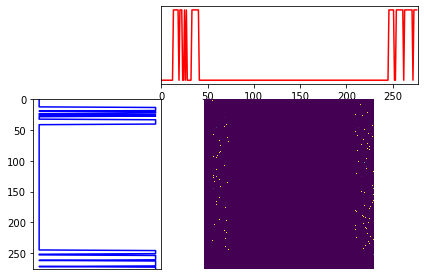

In [216]:
target = compute_user_distribution(target_id)
gamma_emd1 = compute_emd(me, target_id, M_normalized)
gamma_emd2 = compute_emd(me, 1, M_normalized)
import ot.plot

print(gamma_emd1, gamma_emd2)
ot.plot.plot1D_mat(Raito, target, gamma_emd1)

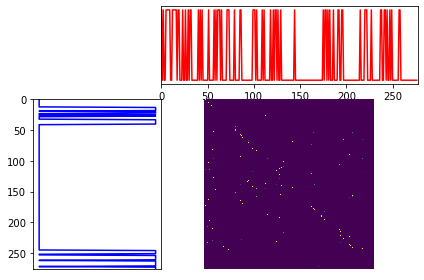

In [217]:
ot.plot.plot1D_mat(Raito, JJ, gamma_emd2)

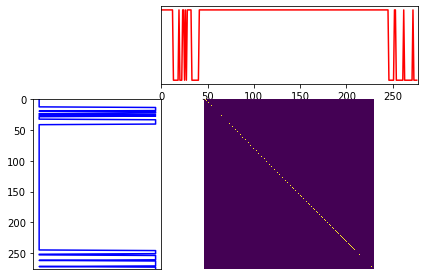

In [218]:
gamma_emd3 = compute_emd(me, me, M_normalized)
ot.plot.plot1D_mat(Raito, Raito, gamma_emd3)

In [219]:
gamma_emd1_normalized = ot.emd2(Raito, target, M_normalized)
gamma_emd1_normalized

0.4888008008151694

In [220]:
import time

SINKHORN_REG = 10
def compute_multiple_wasserstein(source, targets, M):
    start = time.time()
    src = compute_user_distribution(source)
    dsts = np.asarray(list(map(compute_user_distribution, targets)))
    pairwise = []
    print(M.shape)
    print(src.shape)
    pairwise = ot.sinkhorn2(src, dsts.T, M, SINKHORN_REG)
    print(pairwise)
    
    elapsed = time.time() - start
    print('[+] d_W({}, ⋅) has been computed in {:03f} secs.'.format(source, elapsed))
    return pairwise

d_emds = np.asarray([compute_multiple_wasserstein(i, range(1, nb_users), M_normalized) for i in range(1, 10)])

(277, 277)
(277,)
[0.63057932 0.63425403 0.63294459 ... 0.64102428 0.64102428 0.6118727 ]
[+] d_W(1, ⋅) has been computed in 3.562107 secs.
(277, 277)
(277,)
[0.63425403 0.50948549 0.61848221 ... 0.64328068 0.64328068 0.58071851]
[+] d_W(2, ⋅) has been computed in 3.333769 secs.
(277, 277)
(277,)
[0.63294459 0.61848221 0.62106589 ... 0.64086544 0.64086544 0.61063345]
[+] d_W(3, ⋅) has been computed in 3.393731 secs.
(277, 277)
(277,)
[0.63825559 0.59527082 0.62705453 ... 0.64733549 0.64733549 0.59154128]
[+] d_W(4, ⋅) has been computed in 3.416652 secs.
(277, 277)
(277,)
[0.6257096  0.57430286 0.61424733 ... 0.6381296  0.6381296  0.56939176]
[+] d_W(5, ⋅) has been computed in 3.358555 secs.
(277, 277)
(277,)
[0.63965091 0.59136898 0.62594578 ... 0.65090849 0.65090849 0.60099009]
[+] d_W(6, ⋅) has been computed in 3.329718 secs.
(277, 277)
(277,)
[0.640931   0.57827979 0.62371363 ... 0.65241063 0.65241063 0.59514736]
[+] d_W(7, ⋅) has been computed in 3.338925 secs.
(277, 277)
(277,)
[0

In [240]:
d_emds = np.asarray(d_emds)

def plot_wasserstein(index):
    plt.figure(figsize=(20, 10))
    plt.title('Distances de Wasserstein')
    plt.ylabel('$d_W(x_{}, x_i)$'.format(index + 1))
    plt.xlabel('$x_i$')
    plt.scatter(np.arange(d_emds.shape[1]), d_emds[index])

interact(plot_wasserstein, index=widgets.IntSlider(min=0, max=d_emds.shape[0] - 1));

interactive(children=(IntSlider(value=0, description='index', max=8), Output()), _dom_classes=('widget-interac…

In [242]:
df = pd.DataFrame(d_emds.T)

In [243]:
df.describe()

,0,1,2,3,4,5,6,7,8
count,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000,2288.000000
mean,0.633757,0.593838,0.626721,0.621056,0.607121,0.621282,0.616338,0.595881,0.616915
std,0.014778,0.045157,0.016259,0.023763,0.027920,0.023545,0.029755,0.047972,0.033406
min,0.557245,0.466610,0.550074,0.541119,0.521773,0.541494,0.514830,0.319999,0.447002
25%,0.626813,0.565025,0.619367,0.605634,0.588559,0.602640,0.592096,0.563714,0.597219
50%,0.636320,0.596933,0.628891,0.621417,0.607735,0.620143,0.614883,0.599452,0.620879
75%,0.641024,0.635217,0.638621,0.642346,0.632354,0.642830,0.644999,0.640784,0.645635
max,0.762716,0.780506,0.740238,0.785730,0.776860,0.771001,0.775704,0.745717,0.778539
